In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import gensim
from collections import Counter
from string import punctuation

In [15]:
import nltk
from nltk.corpus import stopwords

# EDA #

In [16]:
# Import Dataframes
s_script = pd.read_csv('simpsons_data/simpsons_script_lines.csv')
s_char = pd.read_csv('simpsons_data/simpsons_characters.csv')
s_ep = pd.read_csv('simpsons_data/simpsons_episodes.csv') 
s_loc = pd.read_csv('simpsons_data/simpsons_locations.csv')

/Users/justincarloulim/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
list(s_loc.columns)

['id', 'name', 'normalized_name']

In [17]:
# Create a dataframe that merges both script and the character information.
# Now, we have the gender of each character, as well as their names, the timestamp
# of their speaking lines, and their character id.

script = s_script[['episode_id', 
                   'timestamp_in_ms',
                   'raw_location_text',
                   'raw_character_text', 
                   'spoken_words', 
                   'word_count']].rename(columns = {'raw_character_text': 'name', 
                                                    'spoken_words': 'line'})
chars = s_char.dropna().rename(columns = {'id': 'char_id'})
script_table = script.merge(chars)
script_table = script_table[['episode_id', 'normalized_name', 'char_id', 'gender' , 'line', 'timestamp_in_ms', 'raw_location_text']]
script_table.head()

,episode_id,normalized_name,char_id,gender,line,timestamp_in_ms,raw_location_text
0,32,miss hoover,464,f,"No, actually, it was a little of both. Sometim...",848000,Springfield Elementary School
1,32,miss hoover,464,f,I don't know. Although I'd sure like to talk t...,856000,Springfield Elementary School
2,49,miss hoover,464,f,"Thank you, Ralph. Very graphic. Lisa Simpson? ...",784000,Springfield Elementary School
3,49,miss hoover,464,f,Dear God!,803000,Springfield Elementary School
4,51,miss hoover,464,f,I question the educational value of this assem...,226000,Springfield Elementary School


# Gender Distribution Over Time #

In [18]:
## Testing Idea
test_32 = script_table[['episode_id', 'gender', 'normalized_name']]
test_32 = test_32[test_32['episode_id'] == 32]
test_counts = test_32.groupby('gender').count()
#test_counts

In [22]:
## Create counts table
gdt = script_table[['episode_id', 'gender', 'normalized_name']].sort_values(['episode_id'])
counts_gdt = gdt.groupby(['episode_id', 'gender']).count()
counts_gdt

m_dist = []
f_dist = []

n = len(counts_gdt)
for i in range(n):
    if i % 2 == 0:
        f_dist.append(counts_gdt.iloc[i][0])
    else:
        m_dist.append(counts_gdt.iloc[i][0])

        
gdt_table = pd.DataFrame({'female_dist': f_dist, 'male_dist': m_dist}).reset_index()
gdt_table['total'] = [a + b for a, b in zip(f_dist, m_dist)]
gdt_table['female_dist'] = gdt_table['female_dist']/ gdt_table['total']
gdt_table['male_dist'] = gdt_table['male_dist']/ gdt_table['total']
gdt_table['total'] = gdt_table['total']/ gdt_table['total']
gdt_table.head()

,index,female_dist,male_dist,total
0,0,0.278997,0.721003,1.0
1,1,0.233202,0.766798,1.0
2,2,0.257143,0.742857,1.0
3,3,0.291045,0.708955,1.0
4,4,0.188755,0.811245,1.0


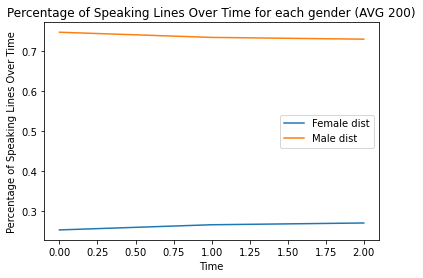

In [67]:
## Graph Distributions

def create_avgs(tbl, n):
    f = []
    m = []

    i = 0
    while i < len(tbl):
        if i + n > len(tbl):
            f.append(np.mean(tbl['female_dist'][i:]))
            m.append(np.mean(tbl['male_dist'][i:]))
        else:
            f.append(np.mean(tbl['female_dist'][i:i+n]))
            m.append(np.mean(tbl['male_dist'][i:i+n]))
        i += n
        
    return f, m


f_avgs, m_avgs = create_avgs(gdt_table, 200)
plt.figure(figsize= (6,4))
plt.plot(f_avgs, label= 'Female dist')
plt.plot(m_avgs, label= 'Male dist')
plt.ylabel('Percentage of Speaking Lines Over Time')
plt.xlabel('Time')
plt.title('Percentage of Speaking Lines Over Time for each gender (AVG 200)')
plt.legend()
plt.show();

# Network Analysis Model #

In [178]:
srt_st = script_table.sort_values(by = ['episode_id', 'timestamp_in_ms'])
srt_st[srt_st['episode_id'] == 1]

,episode_id,normalized_name,char_id,gender,line,timestamp_in_ms,raw_location_text
72629,1,marge simpson,1,f,"Ooo, careful, Homer.",8000.0,Car
57449,1,homer simpson,2,m,There's no time to be careful.,10000.0,Car
57450,1,homer simpson,2,m,We're late.,10000.0,Car
72630,1,marge simpson,1,f,"Sorry, Excuse us. Pardon me...",24000.0,Auditorium
57451,1,homer simpson,2,m,"Hey, Norman. How's it going? So you got dragge...",26000.0,Auditorium
...,...,...,...,...,...,...,...
72670,1,marge simpson,1,f,"Take it, Homer!",1358000.0,Simpson Home
57565,1,homer simpson,2,m,RUDOLPH WITH YOUR NOSE... OVER HERE... / SO YO...,1360000.0,Simpson Home
72671,1,marge simpson,1,f,"Oh, Homer.",1365000.0,Simpson Home
11043,1,lisa simpson,9,f,THEN ALL THE REINDEER LOVED HIM / AS THEY SHOU...,1366000.0,Simpson Home


# Topic Model #

In [44]:
spacy.load('en_core_web_sm')
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))

In [85]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        elif type(token) != str:
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = text.lower()
    for char in punctuation:
        tokens = tokens.replace(char, '')
    tokens = tokens.split()
    return tokens

In [114]:
#script_table['line']

In [103]:
# Lower and remove punctuation from each line, and put
# Into a 2d list
text_data = []
for line in script_table['line']:
    if type(line) != str:
        continue
    tokens = prepare_text_for_lda(line)
    text_data.append(tokens)

111314

In [115]:
quarter_index = int(len(text_data)/4)
text_data_quarter = text_data[: quarter_index]

In [112]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data_quarter]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [113]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.045*"i" + 0.043*"the" + 0.032*"a" + 0.027*"to"')
(1, '0.026*"okay" + 0.014*"gotta" + 0.009*"kid" + 0.007*"thank"')
(2, '0.036*"oh" + 0.027*"no" + 0.020*"my" + 0.020*"im"')
(3, '0.061*"you" + 0.031*"what" + 0.028*"do" + 0.027*"hey"')
(4, '0.022*"uh" + 0.008*"a" + 0.008*"cool" + 0.007*"um"')
